In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image

In [2]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.lr_images), len(self.hr_images))


    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx])).convert('L')
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx])).convert('L')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [4]:
def psnr(pred, target):
    mse = nn.functional.mse_loss(pred, target)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [5]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for lr, hr in tqdm(loader):
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        preds = model(lr)
        loss = criterion(preds, hr)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

In [6]:
def evaluate(model, loader, device):
    model.eval()
    total_psnr = 0
    with torch.no_grad():
        for lr, hr in loader:
            lr, hr = lr.to(device), hr.to(device)
            preds = model(lr)
            total_psnr += psnr(preds, hr).item()
    return total_psnr / len(loader)

In [7]:
# Paths
train_lr = './data/train/LR'
train_hr = './data/train/HR'
test_lr = './data/test/LR'
test_hr = './data/test/HR'

# Parameters
epochs = 20
batch_size = 8
lr_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms - UPDATED with Resize to fix tensor size mismatch error
transform = transforms.Compose([
    transforms.Resize((80, 120)),  # Resize all images to fixed 80x120 (HxW)
    transforms.ToTensor()
])

# Dataset & DataLoader
train_set = SuperResolutionDataset(train_lr, train_hr, transform)
test_set = SuperResolutionDataset(test_lr, test_hr, transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Model, loss, optimizer
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr_rate)

# Training
for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

# Evaluation
score = evaluate(model, test_loader, device)
print(f"Average PSNR on Test Set: {score:.2f} dB")

# Save model
torch.save(model.state_dict(), "srcnn.pth")

100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


Epoch 1/20, Loss: 0.1666


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


Epoch 2/20, Loss: 0.0382


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Epoch 3/20, Loss: 0.0226


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Epoch 4/20, Loss: 0.0142


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


Epoch 5/20, Loss: 0.0138


100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Epoch 6/20, Loss: 0.0117


100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


Epoch 7/20, Loss: 0.0104


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Epoch 8/20, Loss: 0.0089


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch 9/20, Loss: 0.0073


100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch 10/20, Loss: 0.0058


100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


Epoch 11/20, Loss: 0.0047


100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


Epoch 12/20, Loss: 0.0039


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Epoch 13/20, Loss: 0.0033


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch 14/20, Loss: 0.0028


100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


Epoch 15/20, Loss: 0.0025


100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


Epoch 16/20, Loss: 0.0022


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Epoch 17/20, Loss: 0.0019


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


Epoch 18/20, Loss: 0.0017


100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Epoch 19/20, Loss: 0.0015


100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


Epoch 20/20, Loss: 0.0013
Average PSNR on Test Set: 27.06 dB


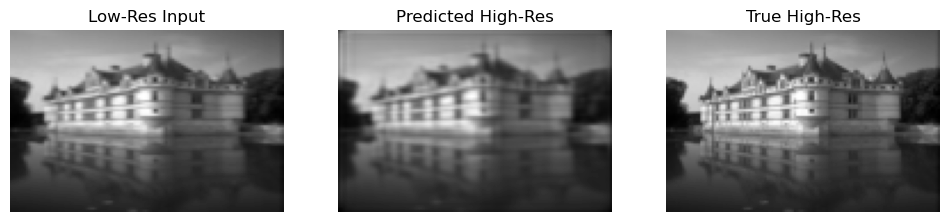

In [8]:
lr_image, hr_image = test_set[0]
lr_image = lr_image.unsqueeze(0).to(device)  
output = model(lr_image).squeeze(0).cpu().detach()  

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Low-Res Input")
plt.imshow(lr_image.squeeze().cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted High-Res")
plt.imshow(output.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("True High-Res")
plt.imshow(hr_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()
output_image = to_pil_image(output)
output_image.save("super_resolved_result.png")